## Using LSTMs, CNNs, GRUs with a larger dataset

In [1]:
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds

### Get the dataset

In [2]:
dataset, info = tfds.load('glue/sst2',with_info=True)
print(info.features)
print(info.features['label'].num_classes)
print(info.features['label'].names)

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [3]:
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [4]:
for example in dataset_train.take(2):
    review, label = example['sentence'], example['label']
    print('Review:', review)
    print('Label: %d \n'% label.numpy())
    

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [5]:
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

for item in dataset_train.take(10000):
    review, label = item['sentence'], item['label']
    training_reviews.append(str(review.numpy()))
    training_labels.append(label.numpy())
    
print('\nNo. of training Review is :',len(training_reviews))

for i in range(0,2):
    print(training_reviews[i])
    print(training_labels[i])
    
for item in dataset_validation.take(-1):
    review, label = item['sentence'], item['label']
    validation_reviews.append(str(review.numpy()))
    validation_labels.append(label.numpy())
    
print('\nNo. of Validation Review is :',len(validation_reviews))

for i in range(0,2):
    print(validation_reviews[i])
    print(validation_labels[i])


No. of training Review is : 10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

No. of Validation Review is : 872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


## Tokenize the words and sequence the sentences

In [6]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type = 'post'
pad_type = 'post'
oov_type = '<OOV>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_type)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

## Pad the sequences

In [7]:
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length,truncating=trunc_type,padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length,truncating=trunc_type,padding=pad_type)

training_label_final = np.array(training_labels)
validation_label_final = np.array(validation_labels)

## Create the model using an Embedding

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epoch=20
history = model.fit(training_padded, training_label_final, epochs=num_epoch, 
          validation_data=(validation_padded,validation_label_final))

Epoch 1/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6843 - accuracy: 0.5503 - val_loss: 0.6876 - val_accuracy: 0.5161
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6721 - accuracy: 0.5734 - val_loss: 0.6721 - val_accuracy: 0.5929
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6515 - accuracy: 0.6211 - val_loss: 0.6456 - val_accuracy: 0.6468
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6221 - accuracy: 0.6739 - val_loss: 0.6139 - val_accuracy: 0.6904
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5886 - accuracy: 0.7104 - val_loss: 0.5819 - val_accuracy: 0.7144
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5543 - accuracy: 0.7451 - val_loss: 0.5546 - val_accuracy: 0.7362
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5224 - accuracy: 0.7696 - val_loss: 0.5324 - val_accuracy: 0.7431
Epoch 

## Plot the accurracy and loss

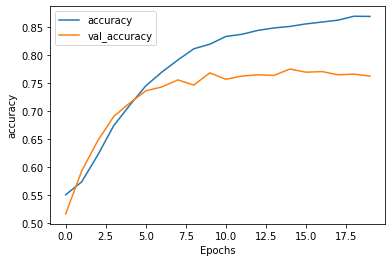

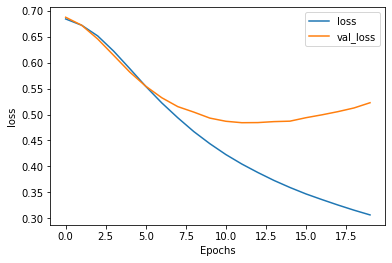

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Write a function to predict the sentiment of reviews

In [15]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [17]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
    classes = model.predict(reviews_padded)
    for x in range(len(reviews_padded)):
        print(reviews[x])
        print(classes[x])
        print('\n')

predict_review(model, new_reviews)


I loved this movie
[0.42377287]


that was the worst movie I've ever seen
[0.12851411]


too much violence even for a Bond film
[0.03461561]


a captivating recounting of a cherished myth
[0.6371176]




## Define a function to train and show the results of models with different layers

In [22]:
def fit_model_and_show_results (model, reviews):
    model.summary()
    history = model.fit(training_padded, training_label_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_label_final))
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")
    predict_review(model, reviews)

# Use a CNN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 2s 4ms/step - loss: 0.6871 - accuracy: 0.5596 - val_loss: 0.6944 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.5590 - val_

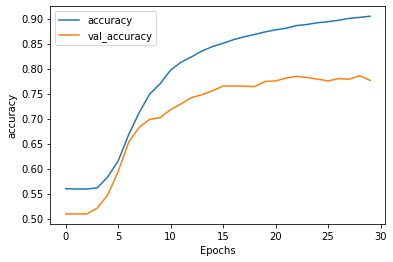

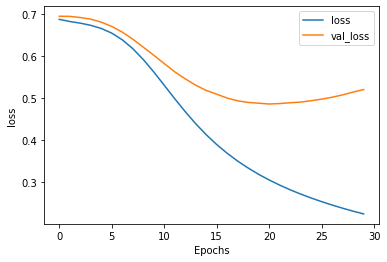

I loved this movie
[0.8591789]


that was the worst movie I've ever seen
[0.02352479]


too much violence even for a Bond film
[0.00525296]


a captivating recounting of a cherished myth
[0.7323147]




In [23]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU


### The Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) that, in certain cases, has advantages over long short term memory (LSTM). GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 11s 24ms/step - loss: 0.6905 - accuracy: 0.5562 - val_loss: 0.6936 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 7s 22ms/step - loss: 0.6871 - accuracy: 0.5590 - val_loss: 0.6950 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 7s 22ms/step - loss: 0.6856 - accuracy:

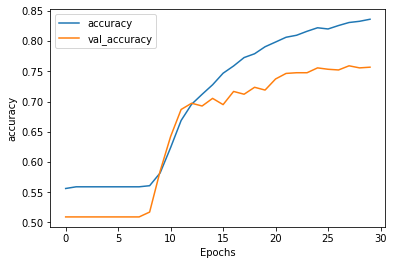

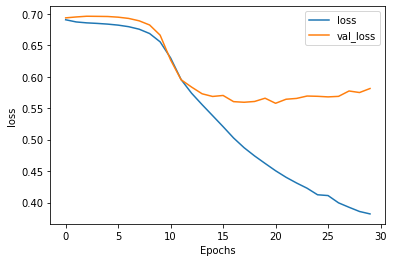

I loved this movie
[0.38676003]


that was the worst movie I've ever seen
[0.18876237]


too much violence even for a Bond film
[0.1434528]


a captivating recounting of a cherished myth
[0.49320048]




In [24]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

## Add a bidirectional LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 10s 24ms/step - loss: 0.6905 - accuracy: 0.5589 - val_loss: 0.6931 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 6s 19ms/step - loss: 0.6873 - accuracy: 0.5590 - val_loss: 0.6944 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 6s 19ms/step - loss: 0.6856 - accuracy:

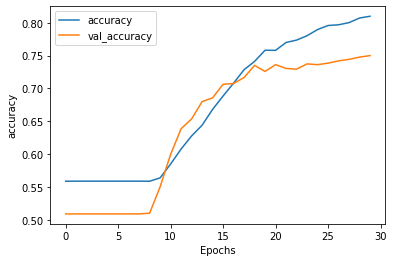

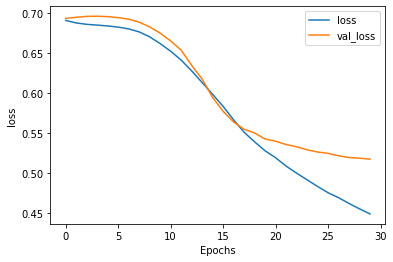

I loved this movie
[0.451805]


that was the worst movie I've ever seen
[0.28201663]


too much violence even for a Bond film
[0.37952876]


a captivating recounting of a cherished myth
[0.47603908]




In [25]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

## Use multiple bidirectional LSTMs

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 20s 48ms/step - loss: 0.6832 - accuracy: 0.5606 - val_loss: 0.6804 - val_accuracy: 0.6067
Epoch 2/30
313/313 [==============================] - 13s 42ms/step - loss: 0.5022 - accuracy: 0.7507 - 

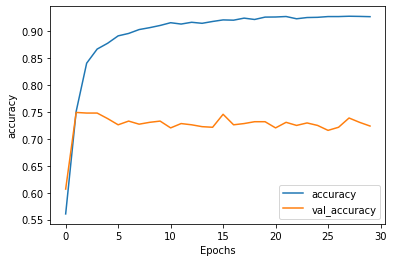

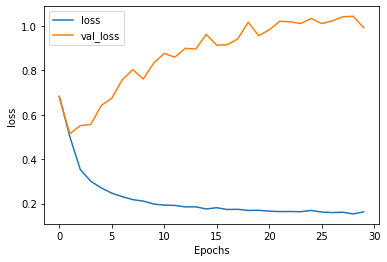

I loved this movie
[0.35706806]


that was the worst movie I've ever seen
[0.02318516]


too much violence even for a Bond film
[0.01350701]


a captivating recounting of a cherished myth
[0.9908416]




In [26]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

## Try some more reviews

In [27]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]


In [28]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.42377287]


that was the worst movie I've ever seen
[0.12851411]


too much violence even for a Bond film
[0.03461561]


a captivating recounting of a cherished myth
[0.6371176]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.3064011]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5237587]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.30880135]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.56345344]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.01145312]


I wish I cou

In [29]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
I loved this movie
[0.8591789]


that was the worst movie I've ever seen
[0.02352479]


too much violence even for a Bond film
[0.00525296]


a captivating recounting of a cherished myth
[0.7323147]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.76072854]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.6719197]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.2451337]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.6436709]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.03816187]


I wish I could watch t

In [30]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
I loved this movie
[0.38676003]


that was the worst movie I've ever seen
[0.18876237]


too much violence even for a Bond film
[0.1434528]


a captivating recounting of a cherished myth
[0.49320048]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.10474741]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.14249772]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.1341244]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.18684256]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.06657568]


I wis

In [31]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.451805]


that was the worst movie I've ever seen
[0.28201663]


too much violence even for a Bond film
[0.37952876]


a captivating recounting of a cherished myth
[0.47603908]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.1868298]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.33552212]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.2241477]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.33272952]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.15480804

In [32]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.35706806]


that was the worst movie I've ever seen
[0.02318516]


too much violence even for a Bond film
[0.01350701]


a captivating recounting of a cherished myth
[0.9908416]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.16137508]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9803375]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.98845685]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.0504339]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0187340